# Dataset Pipeline Validation

In this notebook, we:
- Define image and mask transforms
- Implement CocoSegmentationDataset
- Create DataLoader
- Validate batching and tensor shapes

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from pycocotools.coco import COCO
from PIL import Image

### Load COCO

In [2]:
annotation_path = "../data/annotations/instances_train2017.json"
coco = COCO(annotation_path)

loading annotations into memory...
Done (t=12.41s)
creating index...
index created!


### Define transformers

In [3]:
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(
        (256, 256),
        interpolation=transforms.InterpolationMode.NEAREST
    ),
    transforms.Lambda(
        lambda x: torch.from_numpy(np.array(x)).float().unsqueeze(0)
    )
])

#### Dataset Class

In [4]:
class CocoSegmentationDataset(Dataset):
    def __init__(self, coco, image_folder,
                 category_name='person',
                 image_transform=None,
                 mask_transform=None):

        self.coco = coco
        self.image_folder = image_folder
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        self.cat_ids = self.coco.getCatIds(catNms=[category_name])
        self.img_ids = self.coco.getImgIds(catIds=self.cat_ids)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img_info = self.coco.loadImgs(img_id)[0]

        img_path = os.path.join(
            "../data/train2017",
            img_info['file_name']
        )

        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        ann_ids = self.coco.getAnnIds(
            imgIds=img_info['id'],
            catIds=self.cat_ids,
            iscrowd=None
        )

        anns = self.coco.loadAnns(ann_ids)

        mask = np.zeros((img_info['height'], img_info['width']))

        for ann in anns:
            mask += self.coco.annToMask(ann)

        mask = np.clip(mask, 0, 1).astype(np.uint8)

        if self.image_transform:
            image = self.image_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

#### Create Dataset + DataLoader

In [5]:
dataset = CocoSegmentationDataset(
    coco,
    "../data/train2017",
    image_transform=image_transform,
    mask_transform=mask_transform
)

dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True
)

### Test One Batch

In [6]:
images, masks = next(iter(dataloader))

print("Batch image shape:", images.shape)
print("Batch mask shape:", masks.shape)

Batch image shape: torch.Size([4, 3, 256, 256])
Batch mask shape: torch.Size([4, 1, 256, 256])


### Validate Mask Values

In [7]:
print("Unique mask values:", torch.unique(masks))

Unique mask values: tensor([0., 1.])


### Visualize One Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.2914162].


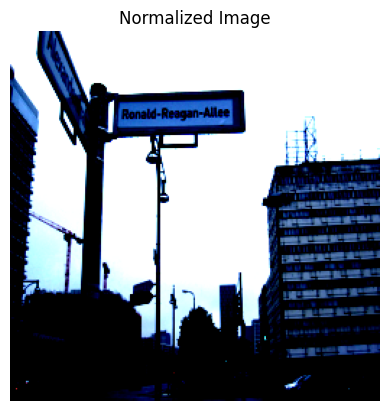

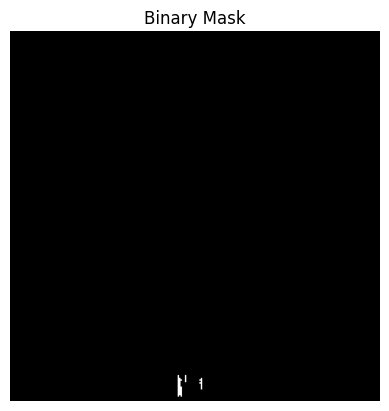

In [8]:
img = images[0]
mask = masks[0]

plt.imshow(img.permute(1,2,0))
plt.title("Normalized Image")
plt.axis("off")
plt.show()

plt.imshow(mask.squeeze(), cmap='gray')
plt.title("Binary Mask")
plt.axis("off")
plt.show()

In [9]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import torch
from src.model import UNet

model = UNet()

x = torch.randn(1, 3, 256, 256)
output = model(x)

print(output.shape)

torch.Size([1, 1, 256, 256])


In [10]:
import torch.nn as nn
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.BCEWithLogitsLoss()

model.train()

images, masks = next(iter(dataloader))

outputs = model(images)

loss = criterion(outputs, masks)

print("Loss:", loss.item())

optimizer.zero_grad()
loss.backward()
optimizer.step()

Loss: 0.6830723881721497


In [12]:
from torch.utils.data import Subset

small_dataset = Subset(dataset, range(200))  # sirf 200 images
small_loader = DataLoader(small_dataset, batch_size=4, shuffle=True)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
images = images.to(device)
masks = masks.to(device)

In [15]:
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in small_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(small_loader)}")

Epoch 1/3, Loss: 0.5298848330974579


KeyboardInterrupt: 